# 🧪 Experimento Mestre (TwiBot-20 e TwiBot-22)

Este notebook roda o experimento completo. **Ele lê a configuração do `src/config.py` para decidir qual dataset carregar.**

**PARA MUDAR O DATASET, EDITE `src/config.py` E MUDE A LINHA `DATASET_MODE`.**

## ⚙️ Passo 0: Configuração do Ambiente

In [1]:
# (Apenas para Colab - Pule se estiver rodando localmente)
print("Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

import os
# (Apenas para Colab - Pule se estiver rodando localmente)
project_path_on_drive = '/content/drive/My Drive/bias-aware-community-detection-test'
os.chdir(project_path_on_drive)
# project_path_on_drive = '..'
# os.chdir(project_path_on_drive)

print(f"Diretório de trabalho: {os.getcwd()}")

print("📦 Instalando e atualizando dependências...")
# (Use !pip3 no Colab, pip no local)
# %pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu130 -q
%pip install --upgrade networkx python-louvain pandas tqdm psutil transformers[torch] matplotlib seaborn tabulate cvxpy ipywidgets -q
print("✅ Dependências instaladas!")

Montando Google Drive...
Mounted at /content/drive
Diretório de trabalho: /content/drive/My Drive/bias-aware-community-detection-test
📦 Instalando e atualizando dependências...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.7/258.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 

In [2]:
print("🔧 Importando módulos e configurando ambiente...")

import sys
import time
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as louvain
import warnings
import random
from collections import defaultdict

# Adicionar 'src' ao sys.path
project_dir_to_add = os.getcwd()
if project_dir_to_add not in sys.path:
    sys.path.append(project_dir_to_add)

# --- LÓGICA DE IMPORTAÇÃO DINÂMICA ---
try:
    from src.config import Config

    # Importar o Loader correto baseado no Config
    if Config.DATASET_MODE == "TWIBOT_20":
        from src.data_utils import TwiBot20Loader as TwiBotDataLoader
    elif Config.DATASET_MODE == "TWIBOT_22":
        from src.data_utils import TwiBot22Loader as TwiBotDataLoader
    else:
        raise ImportError(f"DATASET_MODE '{Config.DATASET_MODE}' não reconhecido.")

    # O BiasCalculator e o resto são os mesmos
    from src.bias_calculator import BiasCalculator
    from src.heuristic import EnhancedLouvainWithBias
    from src.evaluation import ComprehensiveEvaluator
    from src.sdp_model import BiasAwareSDP # Para teste em grafos pequenos

except ImportError as e:
    print(f"❌ ERRO: Não foi possível importar os módulos. Verifique os arquivos .py.")
    print(f"Detalhe: {e}")
    raise e
# --- FIM DA LÓGICA DE IMPORTAÇÃO ---

cfg = Config() # Recarregar config para garantir que o modo está certo
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(cfg.RANDOM_STATE)
random.seed(cfg.RANDOM_STATE)

print("\n--- Verificação de Hardware ---")
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU NÃO DETECTADA. Usando CPU.")
print(f"✅ CPUs: {os.cpu_count()} (Config.NUM_WORKERS={cfg.NUM_WORKERS})")
print(f"✅ MODO DE DATASET: {cfg.DATASET_MODE}")
print("✅ Ambiente pronto!")

🔧 Importando módulos e configurando ambiente...
[Config] Modo TwiBot-22 (CSV/JSONs) ativado.

--- Verificação de Hardware ---
❌ GPU NÃO DETECTADA. Usando CPU.
✅ CPUs: 2 (Config.NUM_WORKERS=2)
✅ MODO DE DATASET: TWIBOT_22
✅ Ambiente pronto!


## 📊 Passo 1: Carregar Grafo

Esta célula agora carrega TwiBot-20 ou TwiBot-22, dependendo do `DATASET_MODE`.

In [3]:
print(f"📊 Carregando/Construindo Grafo (Modo: {cfg.DATASET_MODE})...")
start_load = time.time()

data_loader = TwiBotDataLoader() # Carrega TwiBot20Loader or TwiBot22Loader

# max_nodes=None para carregar o dataset completo
# (Para TwiBot-22, considere usar um número pequeno primeiro, ex: max_nodes=10000)
G, bot_labels = data_loader.load_and_build_graph(max_nodes=None)

load_time = time.time() - start_load
print(f"   ↳ Tempo total: {load_time:.2f}s")
print(f"\n📈 Grafo Carregado: {G.number_of_nodes():,} nós, {G.number_of_edges():,} arestas")
if bot_labels:
    print(f"🎯 Bots Identificados: {sum(bot_labels.values()):,} ({sum(bot_labels.values())/len(bot_labels):.1%})")
else:
    print("⚠️ Nenhum label de bot carregado.")

📊 Carregando/Construindo Grafo (Modo: TWIBOT_22)...
📊 Fase 1: Carregando/Construindo Grafo (TwiBot-22)...
   Início Carga Grafo RAM Usada: 921.4 MB
   Arquivos de cache encontrados! Carregando...
   ✅ Grafo (cache): 693,759 nós, 3,301,024 arestas.
   ↳ Tempo total: 20.25s

📈 Grafo Carregado: 693,759 nós, 3,301,024 arestas
🎯 Bots Identificados: 81,431 (11.7%)


## 🧠 Passo 2: Calcular Scores de Viés

O `BiasCalculator` também usará o `DATASET_MODE` para decidir como buscar os tweets.

🧠 Calculando/Carregando Scores de Viés (Modo: TWIBOT_22)...

🧠 Calculando/Carregando Scores de Viés (Modo: TWIBOT_22)...
   Cache encontrado em '/content/drive/MyDrive/bias-aware-community-detection-test/processed_data_tw22/tw22_bias_scores.json', carregando...
   ↳ Tempo total: 2.13s

📊 Estatísticas do Viés (Nós com tweets: 231,907):
   Média=-0.152, Std=0.289


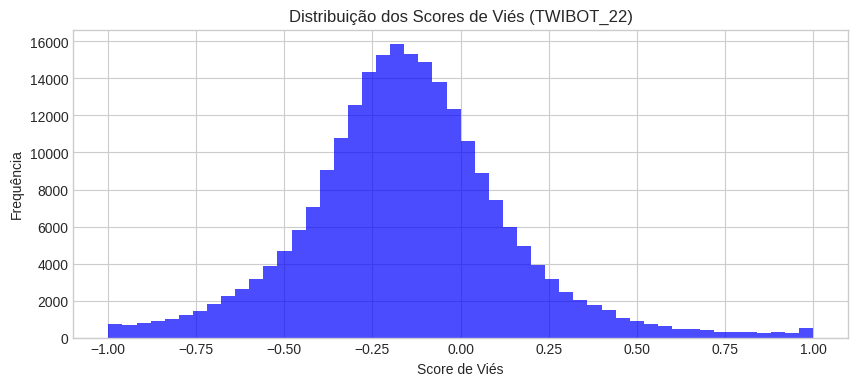

In [4]:
print(f"🧠 Calculando/Carregando Scores de Viés (Modo: {cfg.DATASET_MODE})...")
start_bias = time.time()

bias_calculator = BiasCalculator()

bias_scores = bias_calculator.get_or_calculate_bias_scores(set(G.nodes()))

bias_time = time.time() - start_bias
print(f"   ↳ Tempo total: {bias_time:.2f}s")

# Análise exploratória
bias_values = [s for s in bias_scores.values() if s != 0.0]
if bias_values:
    print(f"\n📊 Estatísticas do Viés (Nós com tweets: {len(bias_values):,}):")
    print(f"   Média={np.mean(bias_values):.3f}, Std={np.std(bias_values):.3f}")

    plt.figure(figsize=(10, 4))
    plt.hist(bias_values, bins=50, alpha=0.7, color='blue')
    plt.title(f'Distribuição dos Scores de Viés ({cfg.DATASET_MODE})')
    plt.xlabel('Score de Viés')
    plt.ylabel('Frequência')
    plt.show()
else:
    print("⚠️ Nenhum score de viés foi calculado (nenhum usuário tinha tweets?).")

## 🎯 Passo 3: Executar Heurística & Baseline

In [ ]:
print(f"\n🎯 Executando Enhanced Louvain com Viés (α={cfg.ALPHA})...")
start_enhanced = time.time()
detector = EnhancedLouvainWithBias(alpha=cfg.ALPHA, verbose=True)
detector.fit(G, bias_scores, num_communities=2)
communities_enhanced = detector.get_communities()
enhanced_time = time.time() - start_enhanced

print("\n⚖️ Executando Louvain Padrão (Baseline)...")
start_louvain = time.time()
communities_louvain = louvain.best_partition(G, random_state=cfg.RANDOM_STATE)
louvain_time = time.time() - start_louvain

print("\n⚙️ Avaliando resultados...")
metrics_enhanced = ComprehensiveEvaluator.evaluate_communities(
    G, communities_enhanced, bias_scores, bot_labels
)
metrics_enhanced['runtime'] = enhanced_time

metrics_louvain = ComprehensiveEvaluator.evaluate_communities(
    G, communities_louvain, bias_scores, bot_labels
)
metrics_louvain['runtime'] = louvain_time
print("✅ Detecção e avaliação concluídas.")


🎯 Executando Enhanced Louvain com Viés (α=0.5)...
🎯 Executando Enhanced Louvain (α=0.5)...
   Fase 1: Executando Louvain padrão para partição inicial...
   Fase 2: Iniciando refinamento iterativo (max_iter=100)...


## 📈 Passo 4: Resultados

In [ ]:
print("\n" + "=" * 60)
print(f"📊 RESULTADOS FINAIS ({cfg.DATASET_MODE})")
print("=" * 60)

ComprehensiveEvaluator.print_comparison(
    metrics_enhanced,
    metrics_louvain,
    "Enhanced Louvain (α=0.5)",
    "Louvain Padrão (α=0.0)"
)

print("\n--- Métricas Detalhadas ---")
df_results = pd.DataFrame({
    "Enhanced Louvain (α=0.5)": metrics_enhanced,
    "Louvain Padrão (α=0.0)": metrics_louvain
}).T

print(df_results[['modularity', 'bias_separation', 'bias_purity', 'bot_concentration_max', 'num_communities', 'runtime']].to_markdown(floatfmt=".4f"))

## 🔬 Passo 5: (Opcional) Teste do SDP

**SÓ RODE SE O GRAFO FOR PEQUENO!** (ex: G.number_of_nodes() < 500)

In [ ]:
if G.number_of_nodes() < 1500:
    print("\n" + "=" * 60)
    print(f"🔬 PASSO 5: Validando com o Modelo SDP (Grafo de {G.number_of_nodes()} nós)")
    print("=" * 60)

    try:
        start_sdp = time.time()
        sdp_detector = BiasAwareSDP(alpha=cfg.ALPHA, verbose=True)
        sdp_detector.fit(G, bias_scores)
        sdp_time = time.time() - start_sdp
        communities_sdp = sdp_detector.get_communities()

        metrics_sdp = ComprehensiveEvaluator.evaluate_communities(
            G, communities_sdp, bias_scores, bot_labels
        )
        metrics_sdp['runtime'] = sdp_time
        print(f"✅ SDP concluído em {sdp_time:.2f}s")

        # 3. Comparação Final
        print("\n\n--- COMPARAÇÃO SDP vs. HEURÍSTICA vs. LOUVAIN ---")
        df_final_comparison = pd.DataFrame({
            "Enhanced Louvain (Heurística)": metrics_enhanced,
            "Bias-Aware SDP (Exato)": metrics_sdp,
            "Louvain Padrão (Baseline)": metrics_louvain
        }).T

        print(df_final_comparison[['modularity', 'bias_separation', 'bias_purity', 'bot_concentration_max', 'num_communities', 'runtime']].to_markdown(floatfmt=".4f"))

        from sklearn.metrics.cluster import adjusted_rand_score
        part_heuristic = [communities_enhanced[node] for node in sorted(G.nodes())]
        part_sdp = [communities_sdp[node] for node in sorted(G.nodes())]
        score = adjusted_rand_score(part_heuristic, part_sdp)

        if score > 0.99:
            print("\n🎉🎉🎉 SUCESSO! A Heurística convergiu para a MESMA solução do SDP!")
        else:
            print(f"\n⚠️ A Heurística NÃO convergiu para a solução do SDP (Adjusted Rand Score: {score:.4f}).")

    except Exception as e:
        print(f"\n❌ ERRO AO RODAR O SDP: {e}")
        print("   Certifique-se de ter 'cvxpy' instalado: !pip install cvxpy")
else:
    print(f"🔬 PASSO 5: Teste do SDP ignorado (Grafo muito grande: {G.number_of_nodes()} nós).")